## Description:

This file contains:
* Using saved model file:
    * predict on unseen 600k non-sub fvids
    * eda on their behavior

In [1]:
"""Helper"""
import pandas as pd
import numpy as np
import time
import joblib

"""Visualization"""
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('darkgrid')
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.float_format', lambda x: '%.2f' % x)

'''Modeling'''
import lightgbm as lgb

'''GCS Utils'''
from gcs_utils import *

'''Modeling Helpers'''
from sklearn.metrics import (f1_score, 
                             auc, 
                             classification_report, 
                             accuracy_score, 
                             confusion_matrix, 
                             plot_confusion_matrix, 
                             precision_recall_curve, 
                             recall_score,
                             precision_score,
                             roc_curve, 
                             roc_auc_score)

SEED = 42

In [2]:
BUCKET_NAME = 'bi-subscription-modeling'
BUCKET_FOLDER = 'train-val-data/pv1-filter-train-val'

file_name = 'pred_ns_pv1_data_01132022.csv'

download_file(BUCKET_NAME, 
              BUCKET_FOLDER, 
              file_name)

BUCKET_FOLDER = 'serialized-objects'

file_name = 'subs_tuned_lgb_model.joblib'
download_file(BUCKET_NAME, 
              BUCKET_FOLDER, 
              file_name)

file_name = 'subs_feat_selected.joblib'
download_file(BUCKET_NAME, 
              BUCKET_FOLDER, 
              file_name)

* **Read serialized objects**

In [2]:
# load model
lgbm_model = joblib.load("./subs_tuned_lgb_model.joblib")
print(lgbm_model)

# load serialized objects
feat_selected = joblib.load("./subs_feat_selected.joblib")
print(len(feat_selected))

LGBMClassifier(colsample_bytree=0.6250410372360866,
               learning_rate=0.2747912388500299, max_depth=11,
               min_child_weight=0.07076031352943153, n_estimators=357,
               num_leaves=69, random_state=42, reg_alpha=4.418320664541417e-08,
               reg_lambda=0.18006075846608585)
59


* **Raw data**

In [3]:
# read data
raw_pred_data = pd.read_csv("./pred_ns_pv1_data_01132022.csv")

# convert fvid column from float to object
raw_pred_data.ga_fullvisitorid = raw_pred_data.ga_fullvisitorid.map(lambda x: '{:.0f}'.format(x)) 

* **Show data**

In [4]:
pred_set = raw_pred_data.copy()
print("Any NAs?: ", pred_set.columns[pred_set.isna().any()])

print("Shape:", pred_set.shape)
print()

# fill any Nulls with 0

pred_set.fillna(0, inplace=True)

# drop unnecessary cols
cols_to_drop = [x for x in pred_set.columns if 'other' in x] + ['ga_fullvisitorid']

pred_set = pred_set.drop(cols_to_drop, 
             axis=1)

pred_set.head()

Any NAs?:  Index([], dtype='object')
Shape: (699887, 613)



,session_pvs_mean,session_pvs_median,session_top_mean,session_top_median,bounce_rate,content_views_rate,rf_content_aggregators,rf_direct,rf_newsletter,rf_organic_search,...,minute_50_top,minute_51_top,minute_52_top,minute_53_top,minute_54_top,minute_55_top,minute_56_top,minute_57_top,minute_58_top,minute_59_top
0,1.00,1.00,2.15,0.00,1.00,1.00,13.00,0.00,0.00,0.00,...,0.00,0.00,13.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,1.00,1.00,51.67,42.00,1.00,1.00,0.00,0.00,0.00,3.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,42.00
2,1.00,1.00,0.00,0.00,1.00,1.00,0.00,0.00,0.00,2.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,1.00,1.00,476.00,476.00,1.00,1.00,0.00,0.00,0.00,2.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,1.50,1.50,24.00,24.00,0.50,1.00,0.00,0.00,0.00,3.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


#### Apply treatments/transformations on pred set to make it model-ready

In [5]:
print("before FS: ", pred_set.shape)

# ---FEATURE SELECT---
pred_set = pred_set[feat_selected]

print("after FS: ", pred_set.shape)

before FS:  (699887, 605)
after FS:  (699887, 59)


In [6]:
# define col names

t1_pv_cols =        [col for col in pred_set.columns if ('t1_' in col) & ('_pvs' in col)]
t1_top_cols =       [col for col in pred_set.columns if ('t1_' in col) & ('_top' in col)]
t2_pv_cols =        [col for col in pred_set.columns if 't2_' in col]
pc_cols =           [col for col in pred_set.columns if 'pc_' in col]
ps_cols =           [col for col in pred_set.columns if 'ps_' in col]
deviceos_cols =     [col for col in pred_set.columns if 'dos_' in col]
referral_cols =     [col for col in pred_set.columns if 'rf_' in col]
country_cols =      [col for col in pred_set.columns if 'ct_' in col]

wk_pv_cols =        [col for col in pred_set.columns if ('week' in col) & ('_pvs' in col)]
wk_top_cols =       [col for col in pred_set.columns if ('week' in col) & ('_top' in col)]
busi_pv_cols =      [col for col in pred_set.columns if ('business_hours' in col) & ('_pvs' in col)]
busi_top_cols =     [col for col in pred_set.columns if ('business_hours' in col) & ('_top' in col)]
dom_cols =          [col for col in pred_set.columns if 'day_of_mon_' in col] 
hour_cols =         [col for col in pred_set.columns if 'hour_' in col] 
dow_cols =          ['friday_top', 'monday_top', 'saturday_top', 'sunday_top', 'thursday_top', 'tuesday_top', 'wednesday_top']

# remove mis-assigned ones
pc_cols.remove('t2_pc_games_pvs')

categorical_cols = (t1_pv_cols +  t1_top_cols + t2_pv_cols + pc_cols + ps_cols + deviceos_cols + referral_cols + country_cols +
                    wk_pv_cols + wk_top_cols + busi_pv_cols + busi_top_cols + dom_cols + hour_cols + dow_cols 
                   )

print(len(categorical_cols))

numerical_cols = ['session_pvs_mean', 'session_top_mean', 'bounce_rate', 'content_views_rate']

print(len(numerical_cols))

# ---NORMALIZE---

from sklearn.preprocessing import normalize

def normalize_pvs(col_list):
    pred_set[col_list] = normalize(pred_set[col_list], norm='l1', axis=1)

normalize_pvs(t1_pv_cols)
normalize_pvs(t2_pv_cols)
normalize_pvs(pc_cols)
normalize_pvs(ps_cols)
normalize_pvs(referral_cols)
normalize_pvs(country_cols)
normalize_pvs(wk_pv_cols)
normalize_pvs(busi_pv_cols)

55
4


* **Prediction set data**
    * eligible people = random sample of 700k non-sub fvids with greater than 1 pv in Dec '21
        * who were not present in our training subs or non-subs fvids <br><br>
    
    * their GA data:
        *  users' activity between 1-Oct-2021 and 31-Dec-2021 - 90 days

* Calibrated model

In [7]:
clf_preiso = joblib.load("clf_preiso.joblib")

In [32]:
thresh = 0.2
preiso_predict_proba = clf_preiso.predict_proba(pred_set)[:, 1]
preiso_pred = np.where(preiso_predict_proba > thresh, 1, 0) 

print("Predicted distribution:")
print(pd.Series(preiso_pred).value_counts())
print()
print("% Subscribers:", round(len(preiso_pred[preiso_pred==1])/len(preiso_pred)*100, 2)) 

Predicted distribution:
0    690455
1      9432
dtype: int64

% Subscribers: 1.35


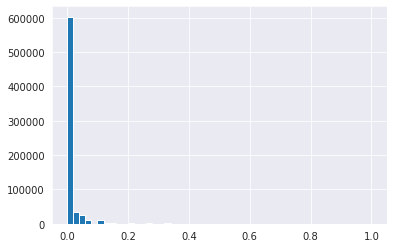

In [19]:
plt.hist(preiso_predict_proba, bins=50)
plt.show()

2734


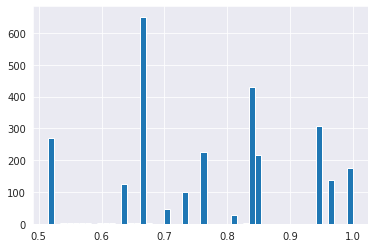

In [20]:
print(len(preiso_predict_proba[preiso_predict_proba>0.5]))

plt.hist(preiso_predict_proba[preiso_predict_proba>0.5], bins=50)
plt.show()

In [25]:
bins = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 1]
test = pd.DataFrame({'preiso_predict_proba':preiso_predict_proba})
test['binned'] = pd.cut(test['preiso_predict_proba'], bins)
test.binned.value_counts()

(0.0, 0.1]    657273
(0.1, 0.2]     15606
(0.2, 0.3]      3590
(0.5, 1.0]      2734
(0.3, 0.4]      1659
(0.4, 0.5]      1449
Name: binned, dtype: int64

In [28]:
test.preiso_predict_proba.describe()

count   699887.00
mean         0.02
std          0.06
min          0.00
25%          0.00
50%          0.00
75%          0.01
max          1.00
Name: preiso_predict_proba, dtype: float64

* **Model predict**

In [7]:
preds = lgbm_model.predict(pred_set)

print("Predicted distribution:")
print(pd.Series(preds).value_counts())
print()
print("% Subscribers:", round(len(preds[preds==1])/len(preds)*100)) 

Predicted distribution:
0    692527
1      7360
dtype: int64

% Subscribers: 1


In [8]:
7360/(7360+692527)

# In 1 month, >1pv folks people = 4MM+ so model will roughly flag 40k people as subs for targeting

0.010515983294446104

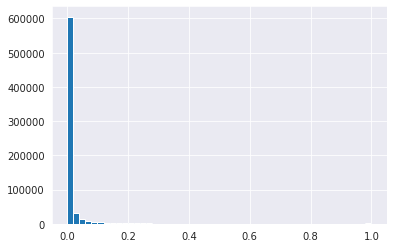

In [30]:
preds_probs = lgbm_model.predict_proba(pred_set)[:,1]
plt.hist(preds_probs, bins=50)
plt.show()

7360


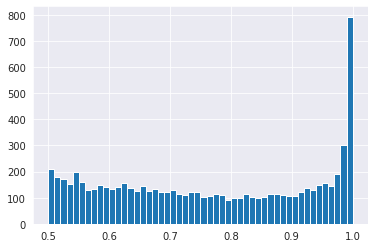

In [12]:
print(len(preds_probs[preds_probs>0.5]))

plt.hist(preds_probs[preds_probs>0.5], bins=50)
plt.show()

* **Thresholding**

In [21]:
def thresholding_preds(thresh, input_pred_set):
    probas = lgbm_model.predict_proba(input_pred_set)
    pred_thresh = np.where(probas[:,1] > thresh, 1, 0)

    print("Predicted distribution:")
    print(pd.Series(pred_thresh).value_counts())
    print()
    print("% Subscribers:", round(len(pred_thresh[pred_thresh==1])/len(pred_thresh)*100)) 

In [22]:
thresholding_preds(0.4, pred_set)

Predicted distribution:
0    690303
1      9584
dtype: int64

% Subscribers: 1


In [25]:
thresholding_preds(0.7, pred_set)

Predicted distribution:
0    695486
1      4401
dtype: int64

% Subscribers: 1


In [11]:
probas = lgbm_model.predict_proba(pred_set)
pred_thresh = np.where(probas[:,1] > 0.3, 1, 0)

print("Predicted distribution:")
print(pd.Series(pred_thresh).value_counts())
print()
print("% Subscribers:", round(len(pred_thresh[pred_thresh==1])/len(pred_thresh)*100)) 

Predicted distribution:
0    686992
1     12895
dtype: int64

% Subscribers: 2


#### EDA on predicted results

In [12]:
raw_pred_data["predictions"] = pred_thresh

raw_pred_data["predicted_class"] = np.where(raw_pred_data["predictions"]==1, 'Subs', 'Non-Subs')

raw_pred_data.predictions.value_counts()

0    686992
1     12895
Name: predictions, dtype: int64

* Average of (unique pageviews in each sessions)

    * **Same as training** - Avg. pv per session is more for subs

In [13]:
raw_pred_data.groupby('predicted_class')['session_pvs_mean'].describe().T

predicted_class,Non-Subs,Subs
count,686992.00,12895.00
mean,1.05,1.29
std,0.20,0.56
min,1.00,1.00
25%,1.00,1.00
50%,1.00,1.00
75%,1.00,1.40
max,7.50,12.00


* Average (sum of time on page in each session)

    * **Same as training** Subs are higher than non-subs

In [14]:
raw_pred_data.groupby('predicted_class').session_top_mean.describe().T

predicted_class,Non-Subs,Subs
count,686992.00,12895.00
mean,134.36,186.15
std,269.75,251.15
min,0.00,0.00
25%,15.00,50.73
50%,45.33,106.00
75%,116.75,222.00
max,6454.00,5160.00


In [16]:
def eda(data, columns):
    
    # drop 'other' column
    columns = [x for x in columns if 'other' not in x]
    
    # groupby - calculate sum of pageviews in each category - calculate percentage
    eda_df = data.groupby('predicted_class')[columns].sum().apply(lambda x: (x/x.sum())*100,
                                                                  axis=1).T.sort_values('Subs', ascending=False)
    #rename
    eda_df = eda_df.rename(columns={"Subs": "% of Subs pvs", "Non-Subs": "% of Non-Subs pvs"})

    #calculate rank
    eda_df['Subs_rank'] = eda_df['% of Subs pvs'].rank(ascending=False).astype(int)
    eda_df['NonSubs_rank'] = eda_df['% of Non-Subs pvs'].rank(ascending=False).astype(int)
    
    return eda_df


# make categorical cols
referral_cols =     [col for col in raw_pred_data.columns if 'rf_' in col]
country_cols =      [col for col in raw_pred_data.columns if 'ct_' in col]
deviceos_cols =     [col for col in raw_pred_data.columns if 'dos_' in col]

t1_pv_cols =        [col for col in raw_pred_data.columns if ('t1_' in col) & ('_pvs' in col)]
t2_pv_cols =        [col for col in raw_pred_data.columns if 't2_' in col]
pc_cols =           [col for col in raw_pred_data.columns if 'pc_' in col]
ps_cols =           [col for col in raw_pred_data.columns if 'ps_' in col]

# remove mis-assigned ones
pc_cols.remove('t2_pc_games_pvs')
ps_cols.remove('t1_family_and_relationships_pvs')
ps_cols.remove('t1_family_and_relationships_top')
ps_cols.remove('t2_apprenticeships_pvs')
ps_cols.remove('t2_celebrity_relationships_pvs')

### Pageviews in referral sources, country, device OS

* **Same as training**
    * Subs more from organic search, referral, social, newsletter
    * Non-subs more from content aggregators, direct
    
* **Differs** 
    * Compared to training data
        * Subs % pvs in content aggregators higher than social (forbes and dark)
        
            * Maybe cz these folks are currently non-subs so coming from these channels but model predicted = high propensity to sub given overall behavior

In [ ]:
# Future TODO: use indexing instead of ranking in EDA

predicted_class,% of Non-Subs pvs,% of Subs pvs,Subs_rank,NonSubs_rank
rf_organic_search,53.30,55.98,1,1
rf_direct,15.83,23.65,2,3
rf_content_aggregators,29.09,6.72,3,2
rf_referral,0.21,6.03,4,5
rf_organic_social_dark,1.47,5.46,5,4
rf_organic_social_forbes,0.06,1.39,6,6
rf_newsletter,0.00,0.51,7,11
rf_push_notification,0.00,0.20,8,9
rf_paid_search,0.03,0.05,9,7
rf_paid_display,0.00,0.00,10,10


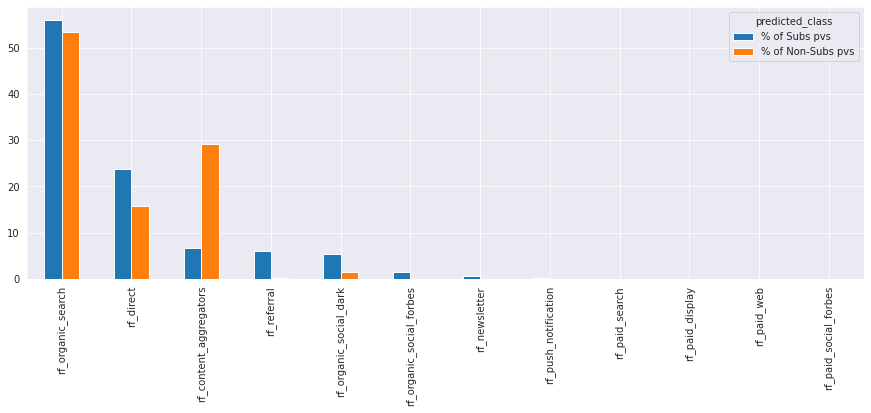

In [17]:
eda(raw_pred_data, referral_cols)[["% of Subs pvs", "% of Non-Subs pvs"]].plot(kind='bar', figsize=(15,5))

eda(raw_pred_data, referral_cols)

* **Differs** 
    * Predicted subs have far less pvs from desktop compared to phone 
        * (they are currenlty non-subs coming from phones more but have overall reading behavior like subs?)

predicted_class,% of Non-Subs pvs,% of Subs pvs,Subs_rank,NonSubs_rank
dos_android,55.03,61.37,1,1
dos_ios,44.62,36.40,2,2
dos_windows,0.06,1.41,3,4
dos_macintosh,0.29,0.83,4,3


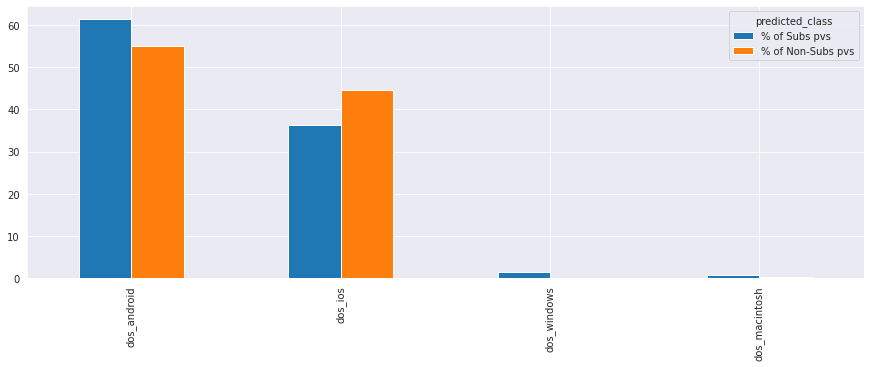

In [18]:
eda(raw_pred_data, deviceos_cols)[["% of Subs pvs", "% of Non-Subs pvs"]].plot(kind='bar', figsize=(15,5))

eda(raw_pred_data, deviceos_cols)

* **Same as training**
    * Mostly all same
    
* **Differs** 
    * Subs have slighlty more pvs in Personal Finance
    * Predicted subs also reading video game (more %pvs than training data)

predicted_class,% of Non-Subs pvs,% of Subs pvs,Subs_rank,NonSubs_rank
t1_business_and_finance_pvs,17.08,27.41,1,2
t1_personal_finance_pvs,12.77,16.35,2,3
t1_technology_and_computing_pvs,17.20,9.91,3,1
t1_news_and_politics_pvs,8.22,6.50,4,5
t1_video_gaming_pvs,12.74,6.39,5,4
t1_medical_health_pvs,7.94,4.77,6,6
t1_sports_pvs,3.11,2.40,7,7
t1_automotive_pvs,1.57,2.40,7,12
t1_travel_pvs,1.99,2.39,9,10
t1_science_pvs,2.07,2.36,10,9


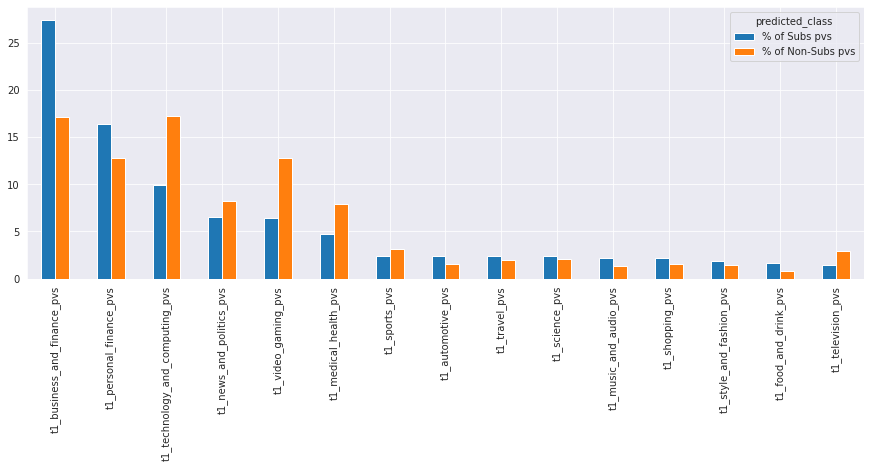

In [20]:
eda(raw_pred_data, t1_pv_cols).head(15)[["% of Subs pvs", "% of Non-Subs pvs"]].plot(kind='bar', figsize=(15,5))

eda(raw_pred_data, t1_pv_cols).head(15)

predicted_class,% of Non-Subs pvs,% of Subs pvs,Subs_rank,NonSubs_rank
t1_business_and_finance_pvs,17.02,26.34,1,2
t1_personal_finance_pvs,12.74,16.27,2,4
t1_technology_and_computing_pvs,17.27,9.57,3,1
t1_video_gaming_pvs,12.78,7.10,4,3
t1_news_and_politics_pvs,8.23,6.49,5,5
t1_medical_health_pvs,7.96,5.18,6,6
t1_science_pvs,2.06,2.66,7,9
t1_sports_pvs,3.12,2.34,8,7
t1_automotive_pvs,1.57,2.33,9,12
t1_travel_pvs,1.99,2.27,10,10


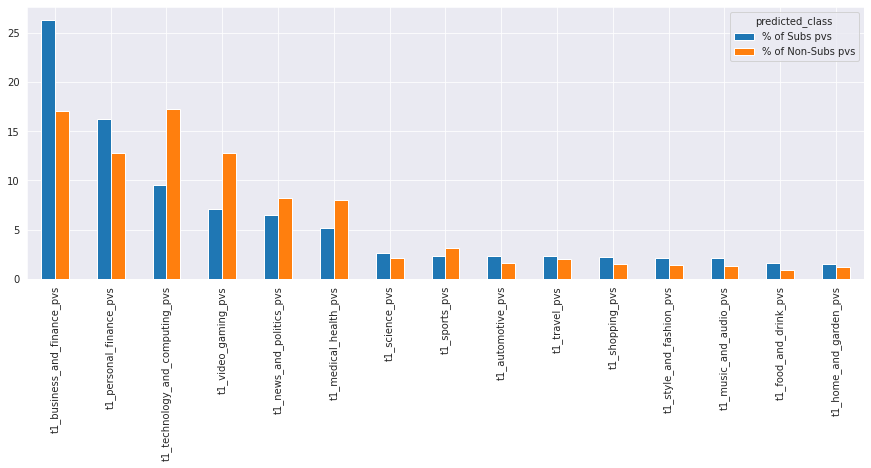

In [19]:
eda(raw_pred_data, t1_pv_cols).head(15)[["% of Subs pvs", "% of Non-Subs pvs"]].plot(kind='bar', figsize=(15,5))

eda(raw_pred_data, t1_pv_cols).head(15)

* **Same as training**
    * Leadership, small business, billionaires, innovation imp
    * Mostly all same
    
* **Differs** 
    * Subs slightly less % pvs in Business (maybe PC encoding inconsistency)

predicted_class,% of Non-Subs pvs,% of Subs pvs,Subs_rank,NonSubs_rank
pc_money_pvs,25.85,27.23,1,2
pc_innovation_pvs,40.58,22.03,2,1
pc_business_pvs,20.26,19.19,3,3
pc_leadership_pvs,3.01,13.42,4,5
pc_lifestyle_pvs,6.50,7.67,5,4
pc_small_business_pvs,1.08,3.04,6,6
pc_billionaires_pvs,0.67,2.45,7,7
pc_home_pvs,0.01,1.35,8,19
pc_asia_pvs,0.57,1.13,9,9
pc_real_estate_pvs,0.61,1.04,10,8


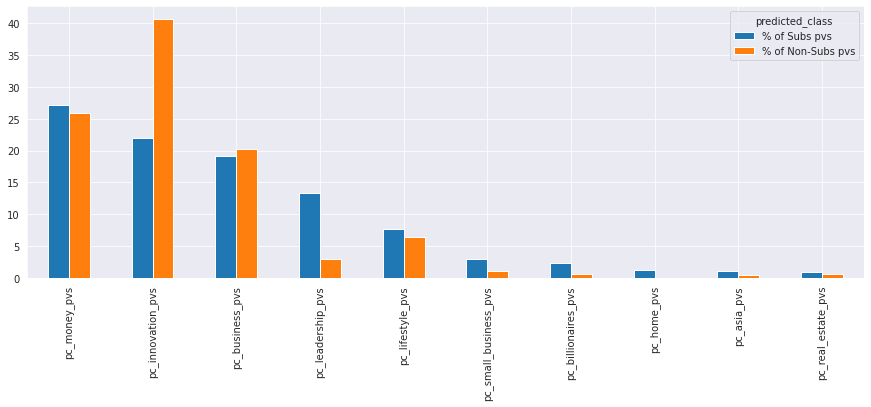

In [21]:
eda(raw_pred_data, pc_cols).head(10)[["% of Subs pvs", "% of Non-Subs pvs"]].plot(kind='bar', figsize=(15,5))

eda(raw_pred_data, pc_cols).head(10)

* **Same as training**
    * Games, tech, leadership, careers, forbes women, crypto = same 
    
* **Differs** 
    * Top 5 ranked categories for subs not ideal. 
    * But subs % pvs still make sense compared to non-subs

predicted_class,% of Non-Subs pvs,% of Subs pvs,Subs_rank,NonSubs_rank
ps_crypto_and_blockchain_pvs,14.04,12.37,1,2
ps_personal_finance_pvs,9.14,9.53,2,4
ps_games_pvs,18.51,8.36,3,1
ps_consumer_tech_pvs,12.87,6.42,4,3
ps_hollywood_and_entertainment_pvs,3.77,5.59,5,7
ps_careers_pvs,1.03,4.12,6,18
ps_markets_pvs,1.71,3.60,7,13
ps_science_pvs,3.66,3.46,8,8
ps_leadership_strategy_pvs,0.83,3.37,9,20
ps_travel_pvs,2.74,3.23,10,10


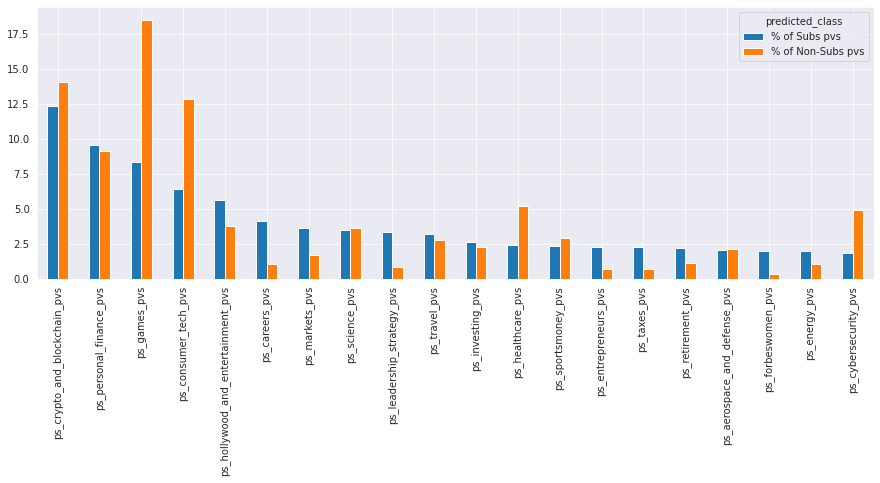

In [22]:
eda(raw_pred_data, ps_cols).head(20)[["% of Subs pvs", "% of Non-Subs pvs"]].plot(kind='bar', figsize=(15,5))

eda(raw_pred_data, ps_cols).head(20)

* **Same as training** - Non-Subs more

In [23]:
raw_pred_data.groupby('predicted_class')['bounce_rate'].describe().T

predicted_class,Non-Subs,Subs
count,692527.00,7360.00
mean,0.95,0.76
std,0.19,0.31
min,0.00,0.00
25%,1.00,0.67
50%,1.00,0.87
75%,1.00,1.00
max,1.00,1.00


* **Same as training** - Non-Subs more

In [24]:
raw_pred_data.groupby('predicted_class')['content_views_rate'].describe().T

predicted_class,Non-Subs,Subs
count,692527.00,7360.00
mean,1.00,0.93
std,0.02,0.16
min,0.00,0.00
25%,1.00,1.00
50%,1.00,1.00
75%,1.00,1.00
max,1.00,1.00
